# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1svDXoEDTdRAMyCcM9VP7-FXWkjRXlr_1?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchtext
import time
import matplotlib.pyplot as plt

In [ ]:
!pip install -U torchtext==0.6

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/MyDrive/Colab Notebooks/APS360 LAB/lab5/sms+spam+collection

/content/gdrive/MyDrive/Colab Notebooks/APS360 LAB/lab5/sms+spam+collection


In [7]:
non_spam= True
for line in open('SMSSpamCollection'):
    if line[0]=='h' and non_spam:
      print(line)
      non_spam= False
    elif line[0]=='s' and not non_spam:
      print(line)
      break

#The lable value for a spam message is "spam"
#The label value for a non-spam message is "ham"

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [8]:
non_spam= True
count1 = 0
count2 = 0
for line in open('SMSSpamCollection'):
    if line[0]=='h':
      count1 += 1
    elif line[0]=='s':
      count2 += 1

print("There are ", count1, "non-spam messages in the data set.")
print("There are ", count2, "spam messages in the data set.")

There are  4827 non-spam messages in the data set.
There are  747 spam messages in the data set.


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
#Advantages:

#1. Modelling messages as a sqeuence of charaters
#requires less memory to store characters
#than to store words.

#2. Reduce the potential risk of mis-spelling in
#words.

#Disadvantages:

#1. The accuracy may be lower than word level RNN.

#2. Modelling messages as a sequence of characters
#increase computational cost because there are more
#tokens, so more hidden layers are required.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [4]:
text_field = torchtext.data.Field(sequential=True,
                                  tokenize=lambda x: x,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True)

label_field = torchtext.data.Field(sequential=False,
                                   use_vocab=False,
                                   is_target=True,
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam'))

dataset = torchtext.data.TabularDataset("SMSSpamCollection",
                                        "tsv",
                                        [('label', label_field),
                                         ('sms', text_field)])


In [5]:
np.random.seed(50)
train_set, valid_set, test_set = dataset.split(split_ratio=[0.6,0.2,0.2],
                                   stratified=True,
                                   strata_field='label')

In [6]:
print("There are ", len(train_set), "training data.")
print("There are ", len(valid_set), "validation data.")
print("There are ", len(test_set), "testing data.")

There are  3343 training data.
There are  1115 validation data.
There are  1114 testing data.


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [7]:
# save the original training examples
old_train_examples = train_set.examples
# get all the spam messages in `train`
train_spam = []
for item in train_set.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_set.examples = old_train_examples + train_spam * 6

# If the model is trained on an imbalanced
# dataset, the model will be biased towards
# the class that has more training data.
# It will learn more features for that class,
# which the model may not generalize well,
# resulting in overfitting.
# Also, the accuracy of the model will not be good.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [8]:
text_field.build_vocab(train_set)
#text_field.vocab.stoi
#text_field.vocab.itos

In [9]:
text_field.vocab.stoi

# "text_field.vocab.stoi" represents a
# dictionary mapping of characters
# that correspond to their numerial
# identifiers. "stoi" means string to
# index

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7dc1d852ff70>>,
            {'<unk>': 0,
             '<pad>': 1,
             ' ': 2,
             'e': 3,
             'o': 4,
             't': 5,
             'a': 6,
             'n': 7,
             'r': 8,
             'i': 9,
             's': 10,
             'l': 11,
             'u': 12,
             '0': 13,
             'h': 14,
             'd': 15,
             '.': 16,
             'c': 17,
             'm': 18,
             'y': 19,
             'w': 20,
             'p': 21,
             'g': 22,
             '1': 23,
             'f': 24,
             'b': 25,
             '2': 26,
             '8': 27,
             'T': 28,
             'k': 29,
             'E': 30,
             'v': 31,
             'S': 32,
             '5': 33,
             'C': 34,
             'I': 35,
             'O': 36,
             '7': 37,
             '4': 38,
             'N': 39,
             'A':

In [10]:
text_field.vocab.itos

# "text_field.vocab.itos" represents a
# list of character tokens that have been
# indexed by their numerical identifiers.
# "itos" means index to string

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 '0',
 'h',
 'd',
 '.',
 'c',
 'm',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 'b',
 '2',
 '8',
 'T',
 'k',
 'E',
 'v',
 'S',
 '5',
 'C',
 'I',
 'O',
 '7',
 '4',
 'N',
 'A',
 '3',
 'x',
 '6',
 'R',
 '!',
 '9',
 ',',
 'U',
 'P',
 'M',
 'W',
 'L',
 'H',
 'D',
 'B',
 'F',
 'Y',
 'G',
 '?',
 '/',
 "'",
 '-',
 '&',
 '£',
 ':',
 'z',
 'X',
 'V',
 'K',
 'j',
 '*',
 'J',
 ')',
 ';',
 '+',
 '"',
 'q',
 '(',
 '#',
 'Q',
 '@',
 '>',
 'Z',
 '=',
 'ü',
 'Ü',
 '$',
 '%',
 '_',
 '‘',
 '\x92',
 '|',
 '[',
 ']',
 '<',
 '’',
 '…',
 '\x93',
 '“',
 '\\',
 'é',
 '\t',
 '\n',
 '–',
 '~',
 '\x91',
 '\x96',
 'É',
 'ì']

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
# <unk> means "unknown." It is used
# to represent words or tokens in the text
# that are not present in the vocabulary.

# <pad> means "padding". It is used to
# ensures that all sequences have the same
# length, making model possible to process
# them efficiently in batches.


### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [16]:
train_iter = torchtext.data.BucketIterator(train_set,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [17]:
count = 0
for batch in train_iter:
  if count < 10:
    print("Batch", count + 1)
    print("Maximum length:", int(batch.sms[1][0]))
    total = 0
    for number in batch.sms[1]:
      total = total + int(batch.sms[1][0]) - int(number)
    print("Total number of <pad> tokens used:",
          total)
    print('')
    count += 1

Batch 1
Maximum length: 152
Total number of <pad> tokens used: 0

Batch 2
Maximum length: 163
Total number of <pad> tokens used: 19

Batch 3
Maximum length: 158
Total number of <pad> tokens used: 2

Batch 4
Maximum length: 34
Total number of <pad> tokens used: 11

Batch 5
Maximum length: 223
Total number of <pad> tokens used: 893

Batch 6
Maximum length: 76
Total number of <pad> tokens used: 65

Batch 7
Maximum length: 42
Total number of <pad> tokens used: 18

Batch 8
Maximum length: 129
Total number of <pad> tokens used: 54

Batch 9
Maximum length: 84
Total number of <pad> tokens used: 55

Batch 10
Maximum length: 147
Total number of <pad> tokens used: 5



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [18]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [19]:
class RNN(nn.Module):

   def __init__(self, hidden_size):
      self.name = "rnn"
      super(RNN, self).__init__()
      input_size = len(text_field.vocab.itos)
      self.ident = torch.eye(input_size)
      self.hidden_size = hidden_size
      self.rnn = nn.RNN(input_size, hidden_size,
                        batch_first=True)
      self.fc = nn.Linear(hidden_size, 2)

   def forward(self, x):
      x = self.ident[x]
      h0 = torch.zeros(1, x.size(0),
                       self.hidden_size) #an initial hidden state
      output, hidden = self.rnn(x, h0)
      output = self.fc(output[:, -1, :])

      return output

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [11]:
def get_accuracy(model, data, batch_size):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_loader = torchtext.data.BucketIterator(data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
    correct, total = 0, 0
    for batch in data_loader:
        labels = batch.label
        output = model(batch.sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [12]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                  epoch)
    return path

In [13]:
def train_rnn(model, train_loader, valid_loader, batch_size = 32, lr = 1e-4, num_epochs = 15):
  torch.manual_seed(1000)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  iters, train_acc, train_losses, val_acc, val_losses = [], [], [], [], []

  train_loader = torchtext.data.BucketIterator(train_set,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

  valid_loader = torchtext.data.BucketIterator(valid_set,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False,
                                           shuffle= True)

  start_time = time.time()
  n = 0

  for epoch in range(num_epochs):
    for batch in train_loader:
      labels = batch.label
      pred = model(batch.sms[0])
      train_loss = criterion(pred, labels)
      train_loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    total_val_loss = 0.0
    i = 0

    for batch in valid_loader:
      labels = batch.label
      pred = model(batch.sms[0])
      loss = criterion(pred, labels)
      total_val_loss += loss.item()
      i += 1

    val_loss = float(total_val_loss)/(i + 1)

    iters.append(n)
    train_losses.append(float(train_loss) / batch_size) # compute *average* loss
    val_losses.append(float(val_loss)/batch_size)

    n += 1

    # Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, batch_size, lr, epoch)
    torch.save(model.state_dict(), model_path)

    train_acc.append(get_accuracy(model, train_set,
                                  batch_size = batch_size))  # compute training accuracy
    val_acc.append(get_accuracy(model, valid_set,
                                batch_size = batch_size))

    print(("Epoch {}: Train accuracy: {} |" +
               "Validation accuracy: {} |" +
           "Train loss: {} |" +
           "Validation loss: {}").format(
                epoch + 1,
                train_acc[epoch],
                val_acc[epoch],
                train_losses[epoch],
                val_losses[epoch]))
  print("Finish Training")
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  # plotting
  plt.title("Training Curve")
  plt.plot(iters, train_losses, label="Train")
  plt.plot(iters, val_losses, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(range(1, num_epochs+1), train_acc, label="Train")
  plt.plot(range(1, num_epochs+1), val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1: Train accuracy: 0.5629248880782624 |Validation accuracy: 0.6439461883408072 |Train loss: 0.02265862561762333 |Validation loss: 0.020546029994471207
Epoch 2: Train accuracy: 0.673520145912784 |Validation accuracy: 0.7246636771300449 |Train loss: 0.01937437802553177 |Validation loss: 0.020144872936523624
Epoch 3: Train accuracy: 0.7534405571215387 |Validation accuracy: 0.7443946188340808 |Train loss: 0.020275799557566643 |Validation loss: 0.019122098055150773
Epoch 4: Train accuracy: 0.8996849610346543 |Validation accuracy: 0.9094170403587444 |Train loss: 0.01012568362057209 |Validation loss: 0.008810900630325906
Epoch 5: Train accuracy: 0.9132813795390482 |Validation accuracy: 0.8762331838565023 |Train loss: 0.0032905777916312218 |Validation loss: 0.009801312576099817
Epoch 6: Train accuracy: 0.9182556789918753 |Validation accuracy: 0.9130044843049328 |Train loss: 0.005171746015548706 |Validation loss: 0.007953439923262017
Epoch 7: Train accuracy: 0.9316862875145083 |Validation

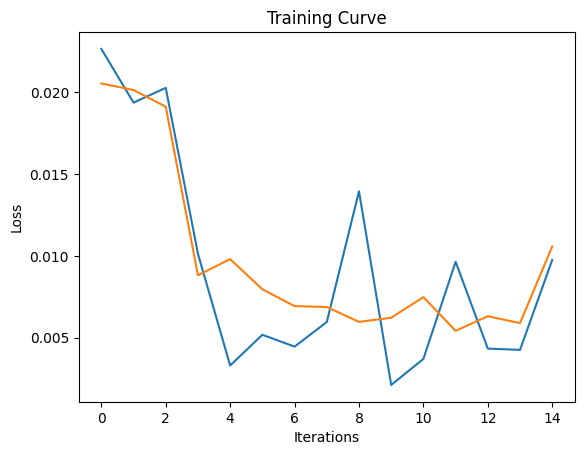

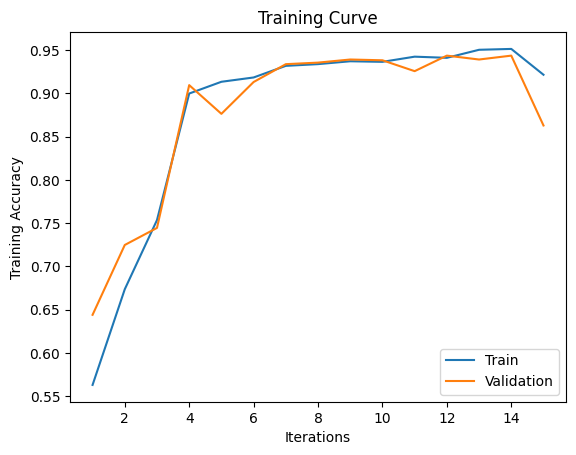

Final Training Accuracy: 0.9214060686453325
Final Validation Accuracy: 0.862780269058296


In [ ]:
model = RNN(50)
train_rnn(model, train_set, valid_set, num_epochs = 15)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1: Train accuracy: 0.639529099651799 |Validation accuracy: 0.5695067264573991 |Train loss: 0.019284600391983986 |Validation loss: 0.021156921413623624
Epoch 2: Train accuracy: 0.7065163322832034 |Validation accuracy: 0.6591928251121076 |Train loss: 0.01868598349392414 |Validation loss: 0.020719253406342533
Epoch 3: Train accuracy: 0.896700381362958 |Validation accuracy: 0.9103139013452914 |Train loss: 0.01588885858654976 |Validation loss: 0.011002155835740268
Epoch 4: Train accuracy: 0.906980600232134 |Validation accuracy: 0.9282511210762332 |Train loss: 0.005148706957697868 |Validation loss: 0.009478047787625756
Epoch 5: Train accuracy: 0.9285358978610513 |Validation accuracy: 0.9273542600896861 |Train loss: 0.0052690389566123486 |Validation loss: 0.007514192819750558
Epoch 6: Train accuracy: 0.9285358978610513 |Validation accuracy: 0.9174887892376682 |Train loss: 0.01037678774446249 |Validation loss: 0.007538714349114646
Epoch 7: Train accuracy: 0.9325153374233128 |Validation a

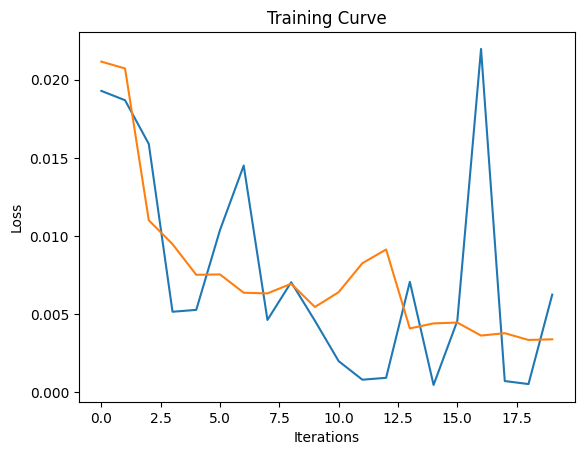

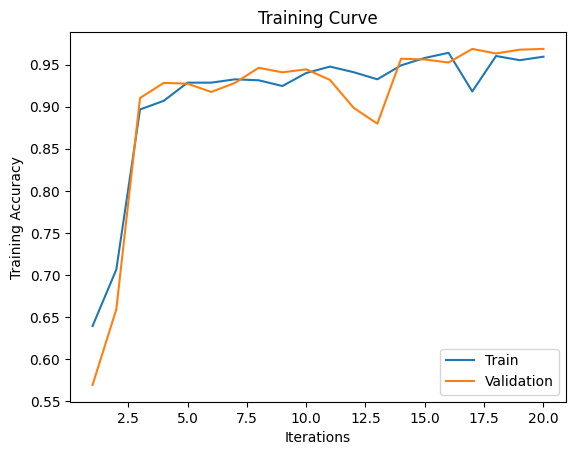

Final Training Accuracy: 0.9593765544685791
Final Validation Accuracy: 0.968609865470852


In [47]:
#Last training:

#Train accuracy: 92.14%
#Val accuracy: 86.27%

#According to the last training,
#The training accuracy and validation
#accuracy plateaued and decreased
#at the end of the last few iterations.
#So, I check whether it will increase
#for more epochs

#I also change the hidden_size to 70,
#allowing the model to capture more
#temporal dependencies.

model_1 = RNN(70)
train_rnn(model_1, train_set, valid_set,
      num_epochs = 20)

In [ ]:
#Last training:

#Train accuracy: 95.93%
#Val accuracy: 96.86%

#The model's accuracy did increase,
#after 15 epochs, so I will keep the
#epoch number the same.

#I will maxpool the entire output array,
#to allow the model focus more on the
#most relevant information.

In [23]:
class RNN_2(nn.Module):

   def __init__(self, hidden_size):
      self.name = "rnn2"
      super(RNN_2, self).__init__()
      input_size = len(text_field.vocab.itos)
      self.ident = torch.eye(input_size)
      self.hidden_size = hidden_size
      self.rnn = nn.RNN(input_size, hidden_size,
                        batch_first=True)
      self.fc = nn.Linear(hidden_size, 2)

   def forward(self, x):
      x = self.ident[x]
      h0 = torch.zeros(1, x.size(0),
                       self.hidden_size) #an initial hidden state
      output, hidden = self.rnn(x, h0)
      output = self.fc(torch.max(output, dim=1)[0])

      return output

Epoch 1: Train accuracy: 0.5208091527109932 |Validation accuracy: 0.13542600896860987 |Train loss: 0.01964990422129631 |Validation loss: 0.022098126252078347
Epoch 2: Train accuracy: 0.5344055712153871 |Validation accuracy: 0.15784753363228698 |Train loss: 0.01856037974357605 |Validation loss: 0.02132007422753506
Epoch 3: Train accuracy: 0.9403084065660753 |Validation accuracy: 0.9219730941704036 |Train loss: 0.01776762679219246 |Validation loss: 0.01922218149734868
Epoch 4: Train accuracy: 0.9167633891560272 |Validation accuracy: 0.9542600896860987 |Train loss: 0.008744941093027592 |Validation loss: 0.012729128150062429
Epoch 5: Train accuracy: 0.9247222682805505 |Validation accuracy: 0.9632286995515695 |Train loss: 0.008329820819199085 |Validation loss: 0.00901700031115777
Epoch 6: Train accuracy: 0.9379870668214226 |Validation accuracy: 0.9605381165919282 |Train loss: 0.006438062991946936 |Validation loss: 0.007285403656876749
Epoch 7: Train accuracy: 0.8234123694246394 |Validation 

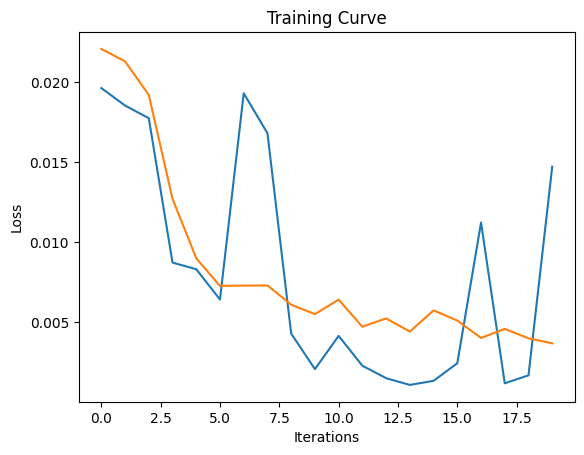

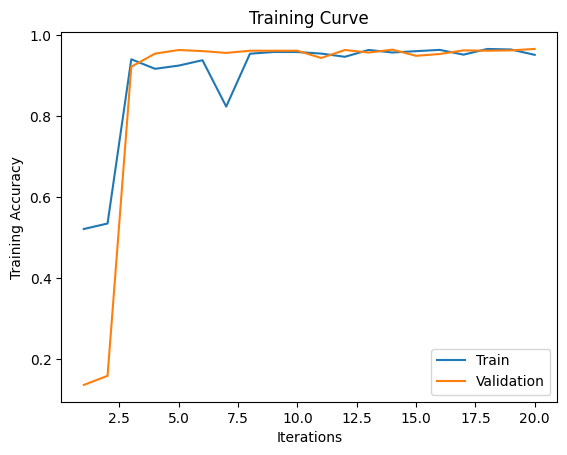

Final Training Accuracy: 0.9512518653622948
Final Validation Accuracy: 0.9659192825112107


In [48]:
model_2 = RNN_2(70)
train_rnn(model_2, train_set, valid_set,
          num_epochs = 20)

In [ ]:
#Last training:

#Train accuracy: 95.12%
#Val accuracy: 96.59%

#The validation accuracy did not
#outperform the validation accuracy
#from model_2, I will try another
#output layer, which applies both
#max pooling and average pooling.

#I will increase the learning_rate
#to see if the accuracy converge faster.

In [14]:
class RNN_3(nn.Module):

   def __init__(self, hidden_size):
      self.name = "rnn3"
      super(RNN_3, self).__init__()
      input_size = len(text_field.vocab.itos)
      self.ident = torch.eye(input_size)
      self.hidden_size = hidden_size
      self.rnn = nn.RNN(input_size, hidden_size,
                        batch_first=True)
      self.fc = nn.Linear(hidden_size*2, 2)

   def forward(self, x):
      x = self.ident[x]
      h0 = torch.zeros(1, x.size(0),
                       self.hidden_size) #an initial hidden state
      output, hidden = self.rnn(x,h0)
      output = torch.cat([torch.max(output, dim=1)[0],
                 torch.mean(output, dim=1)], dim=1)
      return self.fc(output)

Epoch 1: Train accuracy: 0.6173105620958381 |Validation accuracy: 0.3201793721973094 |Train loss: 0.018929123878479004 |Validation loss: 0.021086493455287483
Epoch 2: Train accuracy: 0.9389819267119881 |Validation accuracy: 0.9372197309417041 |Train loss: 0.007170564495027065 |Validation loss: 0.013263419943137301
Epoch 3: Train accuracy: 0.9157685292654618 |Validation accuracy: 0.95695067264574 |Train loss: 0.021878672763705254 |Validation loss: 0.007079431101576322
Epoch 4: Train accuracy: 0.9532415851434256 |Validation accuracy: 0.9452914798206278 |Train loss: 0.002721256110817194 |Validation loss: 0.006429190592219432
Epoch 5: Train accuracy: 0.9590449345050572 |Validation accuracy: 0.9524663677130045 |Train loss: 0.004273359663784504 |Validation loss: 0.004782440991321992
Epoch 6: Train accuracy: 0.9494279555629249 |Validation accuracy: 0.968609865470852 |Train loss: 0.0022680191323161125 |Validation loss: 0.0039221085025928915
Epoch 7: Train accuracy: 0.9651799038302106 |Validati

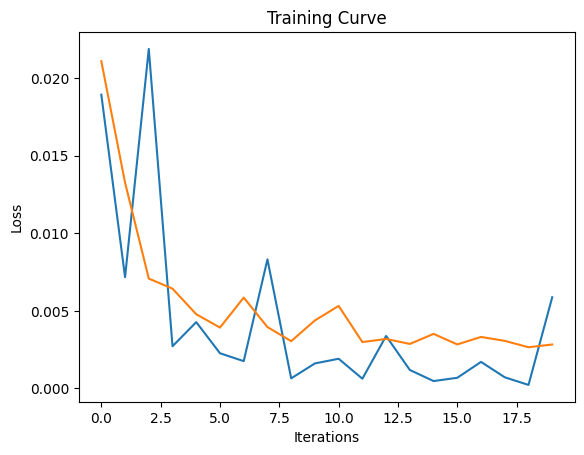

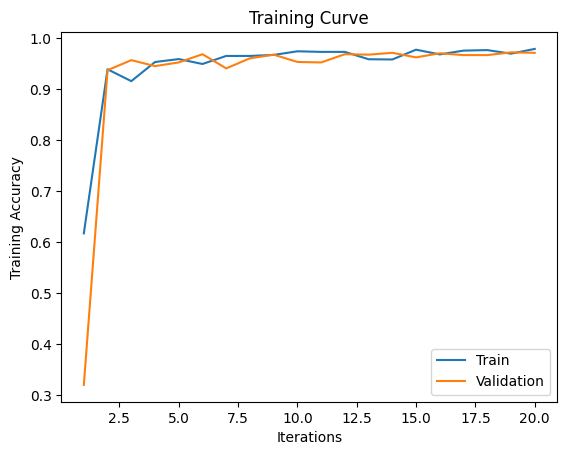

Final Training Accuracy: 0.9789421323163654
Final Validation Accuracy: 0.9713004484304932


In [50]:
model_3 = RNN_3(70)
train_rnn(model_3, train_set, valid_set,
          lr = 2e-4,
          num_epochs = 20)

Epoch 1: Train accuracy: 0.5277731719449511 |Validation accuracy: 0.15426008968609867 |Train loss: 0.018816664814949036 |Validation loss: 0.02152003078824944
Epoch 2: Train accuracy: 0.9025037307245897 |Validation accuracy: 0.8762331838565023 |Train loss: 0.016858283430337906 |Validation loss: 0.01630863630109363
Epoch 3: Train accuracy: 0.9346708671862046 |Validation accuracy: 0.968609865470852 |Train loss: 0.0037434014957398176 |Validation loss: 0.004816408728301112
Epoch 4: Train accuracy: 0.9500911954899685 |Validation accuracy: 0.9695067264573991 |Train loss: 0.004571974743157625 |Validation loss: 0.004191364937772353
Epoch 5: Train accuracy: 0.9575526446692091 |Validation accuracy: 0.9695067264573991 |Train loss: 0.015524014830589294 |Validation loss: 0.003558327987169226
Epoch 6: Train accuracy: 0.9575526446692091 |Validation accuracy: 0.9713004484304932 |Train loss: 0.0023508528247475624 |Validation loss: 0.0038496882480103523
Epoch 7: Train accuracy: 0.9613662742497099 |Valida

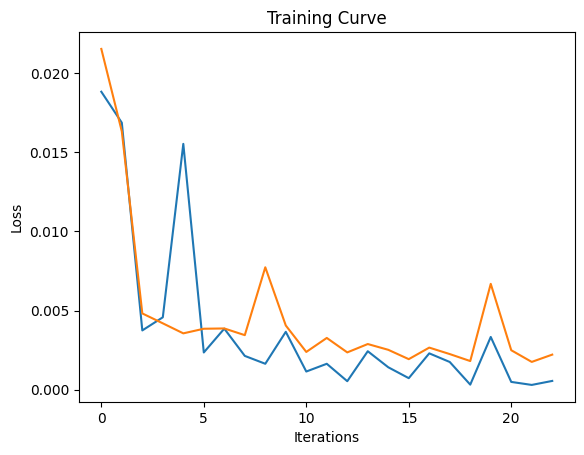

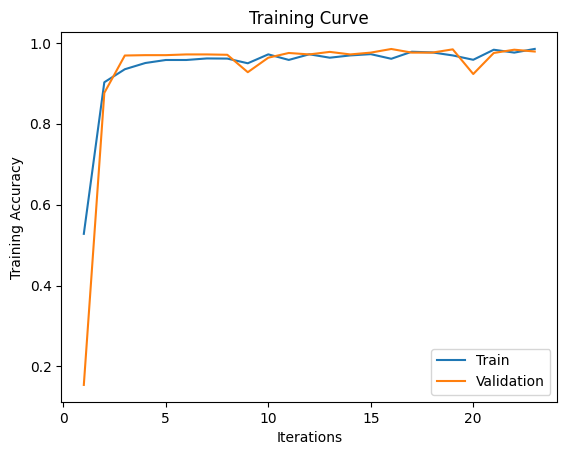

Final Training Accuracy: 0.9849112916597579
Final Validation Accuracy: 0.97847533632287


In [19]:
#Last training:

#Train accuracy: 97.89%
#Val accuracy: 97.13%

#After changing the learning
#rate, the model did achieve
#higher accuracy. I will keep
#it the same.

#I will increase the
#hidden_size, allowing the
#model to pick up more
#dependencies.

#I will also increase the epoch
#to see if the accuracy can
#increase more in the end.

model_4 = RNN_3(80)
train_rnn(model_4, train_set, valid_set,
          lr = 2e-4, num_epochs = 23)

In [58]:
#Model_4 has the best validation
#accuracy: 97.84%

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [20]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid_set.examples if e.label == 1],
    valid_set.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid_set.examples if e.label == 0],
    valid_set.fields)

#error rate on negetive label
false_pos_rate = 1 - get_accuracy(model_4,
                                  valid_nospam,
                                  32)

#error rate on positive label
false_neg_rate = 1 - get_accuracy(model_4,
                                  valid_spam,
                                  32)

print("Model_4's false positive rate is: ",
      false_pos_rate)

print("Model_4's false negative rate is: ",
      false_neg_rate)

Model_3's false positive rate is:  0.01968911917098448
Model_3's false negative rate is:  0.033333333333333326


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
#The impact of a false positive on user
#is that if a user receives a non-spam text,
#the spam detection model will classify
#it as a spam text, which could result in
#missing out important infomation.

#While, the impact of a false negative on
#user is that if a user receives a spam text,
#the algorithm will classify it as a normal
#messages, which could result in the user receiving
#large amount of spam messages.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [21]:
print("The test accuracy of model_4 is: {:2f} %.".format(get_accuracy(model_4, test_set,32)*100))

The test accuracy of model_4 is: 97.396768 %.


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [22]:
test_spam = torchtext.data.Dataset(
    [e for e in test_set.examples if e.label == 1],
    test_set.fields)

test_nospam = torchtext.data.Dataset(
    [e for e in test_set.examples if e.label == 0],
    test_set.fields)

#error rate on negetive label
false_pos_rate_test = 1 - get_accuracy(model_4,
                                  test_nospam,
                                  32)

#error rate on positive label
false_neg_rate_test = 1 - get_accuracy(model_4,
                                  test_spam,
                                  32)

print("Model_4's false positive rate on test_set is: ",
      false_pos_rate_test)

print("Model_4's false negative rate on test_set is: ",
      false_neg_rate_test)

Model_4's false positive rate on test_set is:  0.01968911917098448
Model_4's false negative rate on test_set is:  0.0738255033557047


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [35]:
msg = "machine learning is sooo cool!"

msg_indexed = []

for i in range(len(msg)):
    msg_indexed.append(text_field.vocab.stoi[msg[i]])

message = torch.LongTensor(msg_indexed)
prediction = model_4(message.unsqueeze(0))
prob = F.softmax(prediction, dim=1)
print("The probability of this message to be classfied as spam is: {:f} %.".format(float(prob[0,1]*100)))

The probability of this message to be classfied as spam is: 14.636805 %.


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
#From this lab, I believe that detecting
#spam is not a difficult taks to perform.
#The spam detecting algorithm that I built
#using RNN network in this lab reaches
#high accuracies within reasonable
#iterations.

#One simple baseline model for this spam
#detecting task is that build a model that
#finds the common used words and
#punctuations that appears in common spam
#messages. If these words appear in a
#message, the model will classify it as a
#spam.

#Also, since spam messages are usually
#generated by machine. It has no grammar
#or spelling mistakes. We can improve the
#keyword-checking baseline model to look
#for how the language is used in the
#text to detect whether a message is spam
#or not. It will be easy to distinguish
#a human-written message (usually have
#spelling errors, grammar mistakes, and
#use abbreviations) between a robot-
#-generated message.

In [2]:
%%shell
jupyter nbconvert --to html "/content/Lab5_Spam_Detection.ipynb"

[NbConvertApp] Converting notebook /content/Lab5_Spam_Detection.ipynb to html
[NbConvertApp] Writing 1148690 bytes to /content/Lab5_Spam_Detection.html
